# unzip data

In [ ]:
import shutil
shutil.unpack_archive('archive.zip', '.\\')

In [8]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix 
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import cv2
import os


In [2]:
label_names = ['no_tumor','glioma_tumor','meningioma_tumor','pituitary_tumor']


train_data = []
train_labels = []
train_set = []
test_data = []
test_labels = []
test_set = []

image_size = 200
for i in label_names:
    folderPath = os.path.join('.\\','Training',i) # get folders in training folder

    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        train_data.append(img)
        train_labels.append(label_names.index(i))
        train_set.append([img,label_names.index(i)])
        
for i in label_names:
    folderPath = os.path.join('.\\','Testing',i) # get folders in training folder
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        test_data.append(img)
        test_labels.append(label_names.index(i))
        test_set.append([img,label_names.index(i)])
        
train_data = np.array(train_data)
train_labels = np.array(train_labels)
train_set = np.array(train_set)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
test_set = np.array(test_set)

#Number of classes (2)
num_classes = len(label_names)
num_classes


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


4

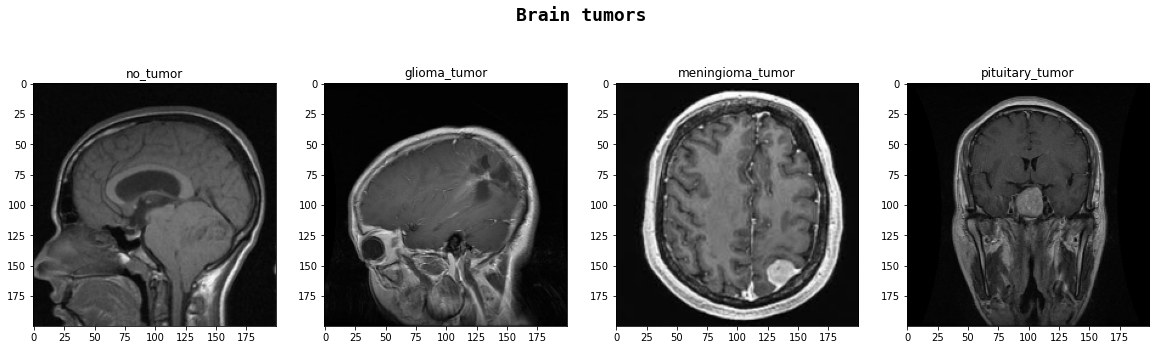

In [3]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Brain tumors',size=18,fontweight='bold',
             fontname='monospace',y=0.63,x=0.46,alpha=1)
for i in range(len(label_names)):
    j=0
    while True :
        if train_labels[j]==i:
            ax[k].imshow(train_data[j])
            ax[k].set_title(label_names[train_labels[j]])
            k+=1
            break
        j+=1

In [4]:
train_data.shape

(2870, 200, 200, 3)

In [5]:
test_data.shape

(394, 200, 200, 3)

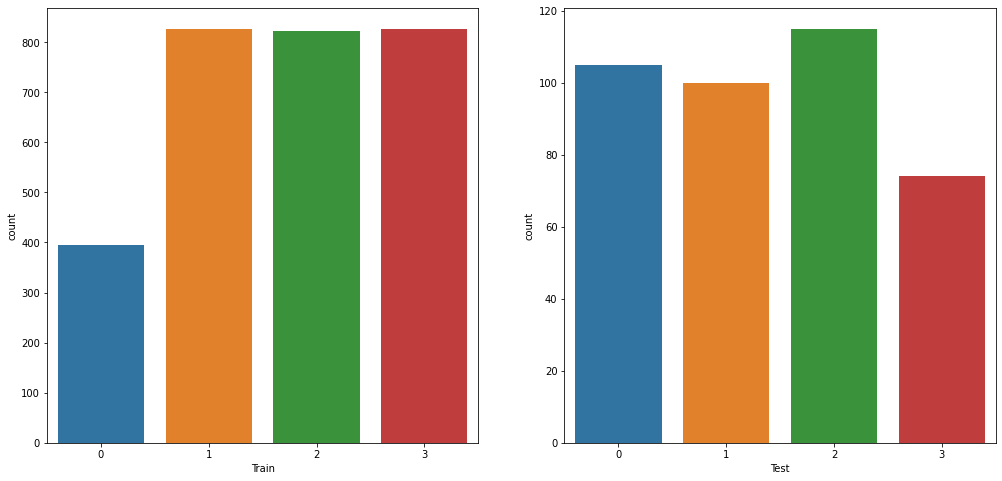

In [6]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

### Data Augmentation using Keras's Image Data Generator

In [9]:
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_data)
img_datagen.fit(test_data)

# Model Building

In [11]:
model = models.Sequential()
#First convolution layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
#First maxpooling layer
model.add(layers.MaxPooling2D((2, 2)))
#Second convolution layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#Second maxpooling layer
model.add(layers.MaxPooling2D((2, 2)))
#Third convolution layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#Third maxpooling layer
model.add(layers.MaxPooling2D((2, 2)))
#Convert the matrix to a fully connected layer
model.add(layers.Flatten())
#Dense function to convert to 32 values
model.add(layers.Dense(32, activation='relu'))
#Final dense convert to 4 classes
model.add(layers.Dense(4))

2022-05-07 19:09:58.618026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 19:09:58.731223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 19:09:58.731939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 19:09:58.733084: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
#Model structures after setting
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)             0

### Model Training

In [13]:
#Model compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#Model fit (epoch)
random.seed(42)
history = model.fit(train_data, train_labels, epochs=10, 
                    validation_data=(test_data, test_labels))

2022-05-07 19:12:26.635799: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-05-07 19:12:27.864348: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


90/90 [==============================] - 9s 26ms/step - loss: 5.0457 - accuracy: 0.6171 - val_loss: 2.7729 - val_accuracy: 0.3553
Epoch 2/10
90/90 [==============================] - 2s 20ms/step - loss: 0.4978 - accuracy: 0.8115 - val_loss: 2.1472 - val_accuracy: 0.5330
Epoch 3/10
90/90 [==============================] - 2s 20ms/step - loss: 0.2944 - accuracy: 0.8934 - val_loss: 2.6913 - val_accuracy: 0.6675
Epoch 4/10
90/90 [==============================] - 2s 20ms/step - loss: 0.1719 - accuracy: 0.9401 - val_loss: 3.7710 - val_accuracy: 0.6574
Epoch 5/10
90/90 [==============================] - 2s 20ms/step - loss: 0.1427 - accuracy: 0.9491 - val_loss: 3.5911 - val_accuracy: 0.7081
Epoch 6/10
90/90 [==============================] - 2s 21ms/step - loss: 0.0802 - accuracy: 0.9739 - val_loss: 4.1190 - val_accuracy: 0.6904
Epoch 7/10
90/90 [==============================] - 2s 20ms/step - loss: 0.0971 - accuracy: 0.9721 - val_loss: 3.6037 - val_accuracy: 0.7157
Epoch 8/10
90/90 [======

### History of Model accuracy and loss plots

In [14]:
#Plots function
def show_plots(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    train_loss, train_acc = model.evaluate(train_data,  train_labels, verbose=0)
    test_loss, test_acc = model.evaluate(test_data,  test_labels, verbose=0)
    print(f"Train_Accuracy:{round(train_acc,4)*100}%   "f"Train_Loss:{round(train_loss,4)}")
    print(f"Test_Accuracy:{round(test_acc,4)*100}%   "f"Test_Loss:{round(test_loss,4)}")

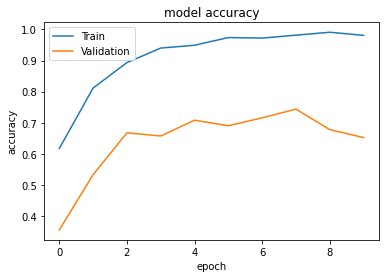

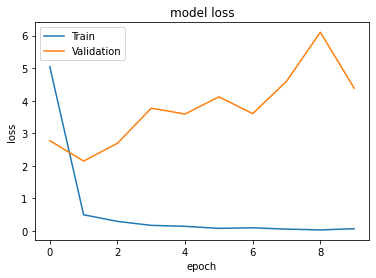

Train_Accuracy:93.55%   Train_Loss:0.1914
Test_Accuracy:65.23%   Test_Loss:4.3866


In [15]:
show_plots(history)

### Confusion Matrix

In [16]:
#confusion matrix function
def show_matrix(model):
    predict=model.predict(test_data) 
    predict_labels=np.argmax(predict,axis=1)
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(test_labels,predict_labels)

    plt.figure(figsize = (8,6))
    ax = sns.heatmap(cf_matrix, annot=True, annot_kws={'size': 20}, cmap='Blues',fmt='g')

    ax.set_title('Brain tumors Confusion Matrix',size= 20);
    ax.set_xlabel('\nPredicted')
    ax.set_ylabel('Actual');
    ax.xaxis.set_ticklabels(label_names,size=10)
    ax.yaxis.set_ticklabels(label_names,size=10, rotation=45)
    ## Display the visualization of the Confusion Matrix.
    plt.show()

    """#Show percentages
    plt.figure(figsize = (8,6))
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', annot_kws={'size': 20}, cmap='Blues')
    ax.set_title('Brain tumors Confusion Matrix',size= 20);
    ax.set_xlabel('\nPredicted')
    ax.set_ylabel('Actual');
    ax.xaxis.set_ticklabels(label_names,size=10)
    ax.yaxis.set_ticklabels(label_names,size=10, rotation=45)
    plt.show()"""


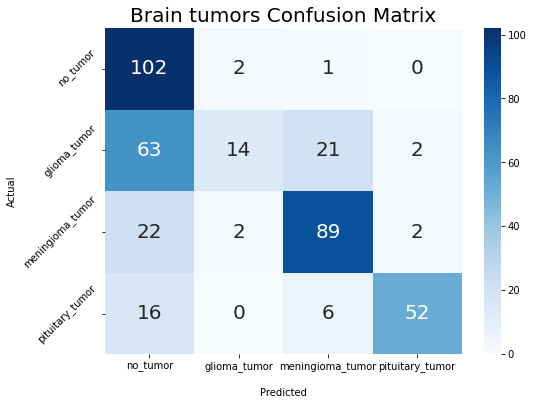

In [17]:
show_matrix(model)

## Experinments
### CNN_Model function

In [18]:
def CNN_Model(Con_1,Con_2,Con_3,Dens_0,act,opti,epoc):

    Conv = []
    Dens =[]
    opt=[]
    epo=[]    
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    model = models.Sequential()
    model.add(layers.Conv2D(Con_1, (3, 3), activation=act, input_shape=(200, 200, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(Con_2, (3, 3), activation=act))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(Con_3, (3, 3), activation=act))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(Dens_0, activation=act))
    model.add(layers.Dense(4))

    model.compile(optimizer=opti,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    random.seed(42)
    history = model.fit(train_data, train_labels, epochs=epoc, 
                        validation_data=(test_data, test_labels), verbose=0)
    train_lo, train_a = model.evaluate(train_data,  train_labels, verbose=0)
    test_lo, test_a = model.evaluate(test_data,  test_labels, verbose=0)
        
    Conv.append([Con_1,act,Con_2,act,Con_3,act])
    Dens.append([Dens_0,act])
    opt.append(opti)
    epo.append(epoc)
    train_loss.append(train_lo)
    train_acc.append(train_a)
    test_loss.append(test_lo)
    test_acc.append(test_a)
    
    np_arr = list(zip(Conv,Dens,opt,epo,train_loss,train_acc,test_loss,test_acc))
    return np_arr,model,history

### Experimenting with the Filters

In [19]:

exp1_1,model1,history1 = CNN_Model(32,32,32,32,"relu","adam",10)
exp1_2,model2,history2 = CNN_Model(64,64,64,32,"relu","adam",10)
exp1_3,model3,history3 = CNN_Model(128,128,128,32,"relu","adam",10)
exp_1=exp1_1+exp1_2+exp1_3
df = pd.DataFrame(exp_1,columns =['Conv','Dens','opt','epo','train_loss','train_acc','test_loss','test_acc'])
df

,Conv,Dens,opt,epo,train_loss,train_acc,test_loss,test_acc
0,"[32, relu, 32, relu, 32, relu]","[32, relu]",adam,10,0.023706,0.993031,4.507954,0.728426
1,"[64, relu, 64, relu, 64, relu]","[32, relu]",adam,10,0.025293,0.989199,6.649053,0.695431
2,"[128, relu, 128, relu, 128, relu]","[32, relu]",adam,10,0.035623,0.987805,6.371019,0.743655


### Change activation function

In [ ]:
#Warning!! it takes about 50 mins to run
exp2_1,model4,history4 = CNN_Model(128,128,128,32,"tanh","adam",10)
exp2_2,model5,history5 = CNN_Model(128,128,128,32,"sigmoid","adam",10)
exp_2=exp2_1+exp2_2
df2 = pd.DataFrame(exp_2,columns =['Conv','Dens','opt','epo','train_loss','train_acc','test_loss','test_acc'])
df2

### Change dense layer

In [ ]:
#Warning!! it takes about 50 mins to run
exp3_1,model6,history6 = CNN_Model(128,128,128,64,"relu","adam",10)
exp3_2,model7,history7 = CNN_Model(128,128,128,128,"relu","adam",10)
exp_3=exp3_1+exp3_2
df3 = pd.DataFrame(exp_3,columns =['Conv','Dens','opt','epo','train_loss','train_acc','test_loss','test_acc'])
df3

### Get Epochs

In [ ]:
#Warning!! it takes about 60 mins to run
exp4,model8,history8 = CNN_Model(128,128,128,32,"relu","adam",20)
df4 = pd.DataFrame(exp4,columns =['Conv','Dens','opt','epo','train_loss','train_acc','test_loss','test_acc'])
df4

### Models compare

In [ ]:
default_model = [([32,"relu",64,"relu",128,"relu"],[32,"relu"],"adam",10,0.1602,0.9519,5.1033,0.7081)]
exp_all=default_model+exp1_1+exp1_2+exp1_3+exp2_1+exp2_2+exp3_1+exp3_2+exp4
df_all = pd.DataFrame(exp_all,columns =['Conv','Dens','opt','epo','train_loss','train_acc','test_loss','test_acc']
                      ,index=['Default_model','Model_1','Model_2','Model_3','Model_4','Model_5','Model_6','Model_7','Model_8'])
df_all

### Find the better Epochs from plots

In [ ]:
show_plots(history7)

### Decide the Epochs to avoid overfitting and get the result of accuracy

In [ ]:
#Warning!! it takes about 60 mins to run
ep_11,model_e11,history_e11 = CNN_Model(128,128,128,32,"relu","adam",11)
ep_6,model_e6,history_e6 = CNN_Model(128,128,128,32,"relu","adam",6)
ep_2,model_e2,history_e2 = CNN_Model(64,64,64,32,"relu","adam",2)

In [ ]:
df_ep=ep_6+ep_11+ep_2
df_ep = pd.DataFrame(df_ep,columns =['Conv','Dens','opt','epo','train_loss','train_acc','test_loss','test_acc']
                      ,index=['Epoch 6','Epoch 11',''])
df_ep

### Compare epoch 6 and epoch 11 model confusion matrix 

In [ ]:
show_matrix(model_e6)

In [ ]:
show_matrix(model_e11)

In [ ]:
from sklearn.metrics import classification_report

test_pred=np.argmax(model_e11.predict(test_data),axis=1)
print(classification_report(test_labels,test_pred))

In [ ]:
test_pred=np.argmax(model_e6.predict(test_data),axis=1)
print(classification_report(test_labels,test_pred))

In [ ]:
# Save better Models which we have found
model.save(f'DMML2 Project/{model_e6.name}.h5')
model.save(f'DMML2 Project/{model_e11.name}.h5')